# Scenario
* You are tasked with investigating customer churn
    * churn: when a customer quits a service.  High churn rate = bad for business.
* in the `data/` folder is a the dataset you will be working on. 


# Complete the following
* Find features that are high indicators of churn and build visualizations
* Build a model to predict churn. You can build any model you want including
    * Logistic Regression 
    * KNN
    * Bayesian Classifiers
* Choose an evaluation metric for your model
    * Accuracy vs Precision vs Recall vs F1
* Explain why you chose that Metric
* Apply a GridsearchCV to find the best hyper parameters for your model
* After you build your final model you must have
    * A confusion matrix supporting your model
    * Final Metric Score
* Make sure you have a validation set for your data


# Can you
* Work in groups? Yes
* Ask cohort-mates for help/advice? Yes
* Check what you did with a cohort-mate? Yes
* Ask me for advice? Yes

This is an opportunity to practice some ML before the Phase 3 project. 


## things to remember
* A data scientist is good at finding key insights to problems not just building models
* validate your model with a confusion matrix and have a validation set

In [1]:
!pip install imblearn

In [2]:
# Import statements
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and EDA

In [3]:
df = pd.read_csv('/Users/jordanrjohnson/DataScienceCourseMaterial/phase_3/dsc-machine-learning-case-study/data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
def churn_rate(y):
    exited = sum(y)
    total_customers = len(y)
    return exited/total_customers

**Metric to use**: recall would be better in this situation because with churn rate, we can implement more customer retention strategies, and misidentifying someone as 'exited' and hitting them with a strategy to keep them engaged would be more beneficial than missing someone who exited and not hitting them with a strategy to keep them subscribed to the service. 

In [5]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# Is there class imbalance?
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

**Options to handle class imbalance:**
* SMOTE
* Use class weights
* Upsampling or downsampling

In [7]:
# What is current churn rate?
churn_rate(df['Exited'])

0.2037

## Put Aside a Blind Validation Set

In [8]:
df_train, df_validation = train_test_split(df, test_size = .1)

In [9]:
df_validation.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3784,3785,15723169,Williams,640,France,Female,31,9,138857.59,1,1,0,48640.77,0
2863,2864,15659175,Severson,755,France,Female,43,9,0.00,2,1,0,18066.69,0
6738,6739,15612358,Christie,573,Germany,Male,35,9,134498.54,2,1,1,119924.80,0
3769,3770,15663263,Collins,698,France,Male,47,5,156265.31,2,0,0,1055.66,0
8217,8218,15635500,Seleznyov,605,Germany,Male,75,2,61319.63,1,0,1,186655.11,0


In [10]:
df_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
794,795,15776807,Brennan,654,France,Male,29,1,0.00,1,1,0,180345.44,0
7653,7654,15788215,Hsia,535,Spain,Female,30,5,122924.75,1,0,0,62390.59,1
7056,7057,15705918,Howarth,725,France,Male,31,8,0.00,2,1,1,59650.42,0
6205,6206,15616221,Wilson,497,France,Female,29,4,85646.81,1,0,0,63233.02,1
2650,2651,15813439,Ch'ien,587,France,Male,33,5,100116.82,1,1,0,34215.58,0


## Build Initial Model

**Model Choice**

This rate is reminding me of a probability given certain features so I will try to build a Naive Bayes Classifier. 

I am also choosing NB because I think I need the most practice with it. :)

In [11]:
features_to_use = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
                   'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
target = ['Exited']

In [12]:
def transform_df(df):
    df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)
    return df

def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap=sns.color_palette('Blues_d'), fmt='0.5g', annot_kws={"size": 16})
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.ylim([0,2])
    plt.show()

In [13]:
df_train_transformed = transform_df(df_train)
df_train_transformed.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
794,795,15776807,Brennan,654,France,1,29,1,0.00,1,1,0,180345.44,0
7653,7654,15788215,Hsia,535,Spain,0,30,5,122924.75,1,0,0,62390.59,1
7056,7057,15705918,Howarth,725,France,1,31,8,0.00,2,1,1,59650.42,0
6205,6206,15616221,Wilson,497,France,0,29,4,85646.81,1,0,0,63233.02,1
2650,2651,15813439,Ch'ien,587,France,1,33,5,100116.82,1,1,0,34215.58,0


In [14]:
X = df_train_transformed[features_to_use]
y = df_train_transformed[target]

g_bayes = GaussianNB()
g_bayes.fit(X, y)

GaussianNB()

In [15]:
df_valid_copy = df_validation.copy()
df_valid_transformed = transform_df(df_valid_copy)

X_valid = df_valid_transformed[features_to_use]
y_valid = df_valid_transformed[target]
g_bayes.score(X_valid, y_valid)

0.77

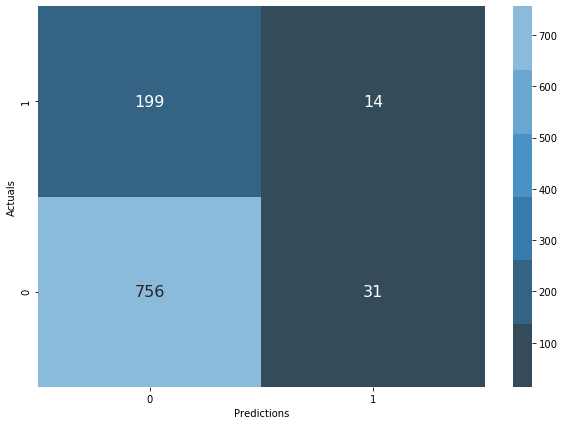

In [16]:
y_valid_preds = g_bayes.predict(X_valid)

plot_conf_matrix(y_valid, y_valid_preds)

## Set up the Pipeline 

**Steps**

1) Choose Columns (need to build a class for this)

2) Transform categorical columns (need a custom class for this too)

3) Deal with class imbalance using SMOTE (imblearn's pipeline will only apply this step to training set)

4) Build model and predict (use existing sklearn methods)

In [17]:
class SelectColumnsTransformer(BaseEstimator):
    def __init__(self, columns=None):
        self.columns = columns
        
    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self
    
class Transform_Categorical():
    def transform(self, X, y=None, **transform_params):
        try:
            X['Gender'] = X['Gender'].apply(bin_gender_func)
        except:
            pass
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def bin_gender_func(x):
        return 1 if x.lower() == 'male' else 0

In [18]:
features_to_use = ['CreditScore', 'Age', 'Tenure', 'Balance',
                   'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
target = ['Exited']

In [19]:
pipeline = Pipeline(steps= [
                    ("ColumnTransformer", SelectColumnsTransformer(columns=features_to_use)),
                    ("TransformCategorical", Transform_Categorical()),
                    ("SMOTE", SMOTE()),
                    ("GaussianBayes", GaussianNB())
                    ])

In [20]:
y_train = df_train[target]
X_train = df_train.drop(columns=['Exited'], axis=1)

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('ColumnTransformer',
                 SelectColumnsTransformer(columns=['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])),
                ('TransformCategorical',
                 <__main__.Transform_Categorical object at 0x1a1cf29320>),
                ('SMOTE', SMOTE()), ('GaussianBayes', GaussianNB())])

In [22]:
df_validation.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3784,3785,15723169,Williams,640,France,Female,31,9,138857.59,1,1,0,48640.77,0
2863,2864,15659175,Severson,755,France,Female,43,9,0.00,2,1,0,18066.69,0
6738,6739,15612358,Christie,573,Germany,Male,35,9,134498.54,2,1,1,119924.80,0
3769,3770,15663263,Collins,698,France,Male,47,5,156265.31,2,0,0,1055.66,0
8217,8218,15635500,Seleznyov,605,Germany,Male,75,2,61319.63,1,0,1,186655.11,0


In [23]:
df_valid_copy2 = df_validation.copy()
y_validation = df_valid_copy2[target]
X_validation = df_valid_copy2.drop(columns=['Exited'], axis=1)

In [24]:
X_validation.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3784,3785,15723169,Williams,640,France,Female,31,9,138857.59,1,1,0,48640.77
2863,2864,15659175,Severson,755,France,Female,43,9,0.00,2,1,0,18066.69
6738,6739,15612358,Christie,573,Germany,Male,35,9,134498.54,2,1,1,119924.80
3769,3770,15663263,Collins,698,France,Male,47,5,156265.31,2,0,0,1055.66
8217,8218,15635500,Seleznyov,605,Germany,Male,75,2,61319.63,1,0,1,186655.11


In [25]:
pipeline.score(X_validation, y_validation)

0.673

## Run GridSearch CV to find best model 


In [26]:
param_grid = {
            "ColumnTransformer__columns": [
                                        ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
                                         'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
                                        ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
                                         'HasCrCard', 'IsActiveMember'],
                                        ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
                                         'HasCrCard', 'EstimatedSalary'],
                                        ['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'],
                                        ['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember',
                                         'EstimatedSalary']
                                        ],
        "SMOTE__sampling_strategy": [0.25, 0.5, 1],
        "GaussianBayes__var_smoothing": [1e-9, 1e-8, 1e-3, 1]
}

In [27]:
gs_pipeline = GridSearchCV(pipeline, param_grid=param_grid, verbose=2)

In [28]:
gs_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Esti

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSal

[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], Ga

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] Colum

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s


[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.0s

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] Colu

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_str

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'A

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance',

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.3s finished


GridSearchCV(estimator=Pipeline(steps=[('ColumnTransformer',
                                        SelectColumnsTransformer(columns=['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary'])),
                                       ('TransformCategorical',
                                        <__main__.Transform_Categorical object at 0x1a1cf29320>),
                                       ('SMOTE', SMOTE()),
             

In [29]:
gs_pipeline.best_estimator_

Pipeline(steps=[('ColumnTransformer',
                 SelectColumnsTransformer(columns=['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])),
                ('TransformCategorical',
                 <__main__.Transform_Categorical object at 0x1a1d51af28>),
                ('SMOTE', SMOTE(sampling_strategy=0.5)),
                ('GaussianBayes', GaussianNB(var_smoothing=0.001))])

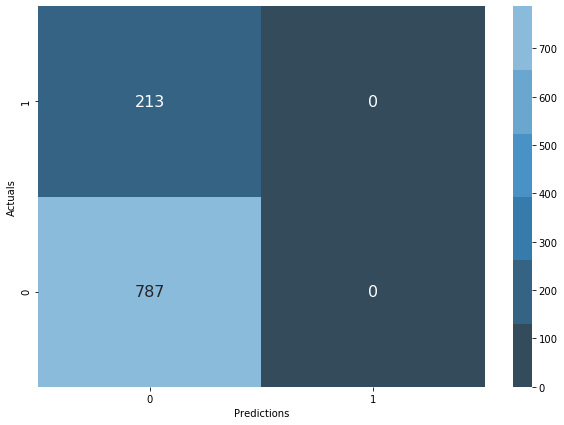

In [30]:
best_nb_accuracy = gs_pipeline.best_estimator_
y_validation_accuracy_preds = best_nb_accuracy.predict(X_validation)
plot_conf_matrix(y_validation, y_validation_accuracy_preds)

In [31]:
gs_pipeline_recall = GridSearchCV(pipeline, param_grid=param_grid, verbose=2, scoring=make_scorer(recall_score))

In [32]:
gs_pipeline_recall.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Esti

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.2s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSal

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.2s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], G

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=1, total=   0.1s
[CV] Colum

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.0s


[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__column

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=0.5, total=

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] Co

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.5, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_str

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember'], GaussianBayes__var_smoothing=0.001, SMOTE__sampling_str

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-09, SMOTE__sampling_strategy=0.25, total=   0.0s
[CV] ColumnTransformer__columns=['CreditScore', 'A

[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1e-08, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'Is

[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5 
[CV]  ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'EstimatedSalary'], GaussianBayes__var_smoothing=1, SMOTE__sampling_strategy=0.5, total=   0.1s
[CV] ColumnTransformer__columns=['CreditScore', 'Age', 'Tenure', 'Balance',

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   15.7s finished


GridSearchCV(estimator=Pipeline(steps=[('ColumnTransformer',
                                        SelectColumnsTransformer(columns=['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary'])),
                                       ('TransformCategorical',
                                        <__main__.Transform_Categorical object at 0x1a1cf29320>),
                                       ('SMOTE', SMOTE()),
             

In [33]:
best_nb_recall = gs_pipeline_recall.best_estimator_
best_nb_recall

Pipeline(steps=[('ColumnTransformer',
                 SelectColumnsTransformer(columns=['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'IsActiveMember'])),
                ('TransformCategorical',
                 <__main__.Transform_Categorical object at 0x1a1c5968d0>),
                ('SMOTE', SMOTE(sampling_strategy=1)),
                ('GaussianBayes', GaussianNB(var_smoothing=0.001))])

In [37]:
y_validation_preds = best_nb_recall.predict(X_validation)

In [38]:
recall_score(y_validation, y_validation_preds)

0.676056338028169

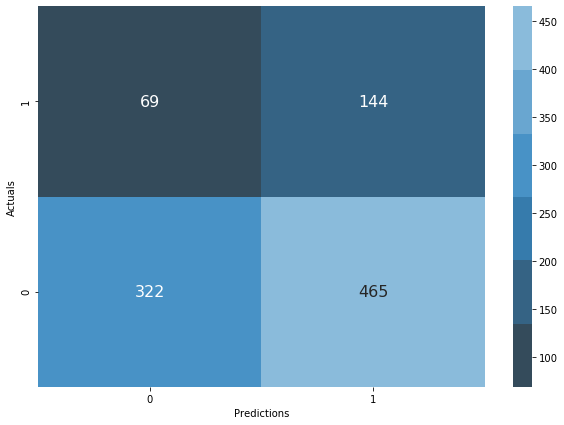

In [39]:
plot_conf_matrix(y_validation, y_validation_preds)

## Conclusion

In conclusion, the confusion matrix above is the best predictor of customers who will exit/churn when we are more focused on recall. It has a recall score of about 68%, so it definitely needs more work. This model produces a lot of false positives, but if our customer retention strategy is to keep these customers engaged, it is not a bad thing to keep a customer engaged who is mispredicted as potentially exiting. The good thing about this model is that out of 1,000 customers, we are only missing 58 people who might exit (the False Negatives). We can continue to tweak this model by experimenting with the gridsearch some more. 


## Challenges

One major challenge in this case study was dealing with the class imbalances while working with a pipeline. Sklearn's pipeline will not let you include SMOTE as a step. After some research I figured out that the reason this happens is because the sklearn pipeline will rebalance/SMOTE both the train and test set. To solve this, imblearn has a pipeline that is built off sklearn but will not rebalance the test set. Overall, this was a great learning experience since working with class imbalance is a common real-world occurrence. 